In [97]:
import os
import sys
import pandas as pd
import numpy as np
import glob
import time
import gget
import scipy
from scipy.sparse import csr_matrix
import anndata as an
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from importlib import reload
import warnings
import ot
from collections import Counter
from itertools import combinations

from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import MinMaxScaler

"""WARNING: no warnings"""
warnings.filterwarnings("ignore")

# local imports
import anndata_utils as anntools

source_path = os.path.abspath("../source/")
sys.path.append(source_path)
import centrality as central
import matrix
import utils as ut
import plotting as plt2

In [2]:
resolution = 1000000
chrom = "chr2"

dpath = "/scratch/indikar_root/indikar1/shared_data/higher_order/by_chromosome/"

file_list = sorted(glob.glob(f"{dpath}*{resolution}*{chrom}*"))
print(file_list)

population_path = file_list[0]
singlecell_path = file_list[1]

print()

print(f"{population_path=}")
print(f"{singlecell_path=}")

['/scratch/indikar_root/indikar1/shared_data/higher_order/by_chromosome/population_mESC_1000000_chr2.h5ad', '/scratch/indikar_root/indikar1/shared_data/higher_order/by_chromosome/singlecell_mESC_1000000_chr2.h5ad']

population_path='/scratch/indikar_root/indikar1/shared_data/higher_order/by_chromosome/population_mESC_1000000_chr2.h5ad'
singlecell_path='/scratch/indikar_root/indikar1/shared_data/higher_order/by_chromosome/singlecell_mESC_1000000_chr2.h5ad'


# Load population data

In [3]:
start_time = time.time()  # Record the start time
adata = sc.read_h5ad(population_path)
end_time = time.time()  # Record the end time
print(f"Time taken to read the file: {end_time - start_time:.2f} seconds")
sc.logging.print_memory_usage()
adata

Time taken to read the file: 10.89 seconds
Memory usage: current 0.95 GB, difference +0.95 GB


AnnData object with n_obs × n_vars = 179 × 186499
    obs: 'bin_index', 'bin_start', 'bin_end', 'bin', 'chrom', 'chrom_bin', 'degree', 'genes', 'n_genes', 'ATACSeq_1', 'ATACSeq_2', 'ATACSeq_3', 'CTCF', 'H3K27ac', 'H3K27me3', 'RNA_1', 'RNA_2', 'RNA_3', 'RNA_4', 'RNA_5', 'RNA_6', 'chrom_degree'
    var: 'read_index', 'basename', 'mean_mapq', 'median_mapq', 'n_chromosomes', 'order', 'n_bins', 'read_length_bp', 'genes', 'n_genes', 'chrom_order'
    uns: 'base_resolution', 'chrom_sizes', 'gene_map'

# Load single-cell data

In [4]:
start_time = time.time()  # Record the start time
bdata = sc.read_h5ad(singlecell_path)
end_time = time.time()  # Record the end time
print(f"Time taken to read the file: {end_time - start_time:.2f} seconds")
sc.logging.print_memory_usage()
bdata

Time taken to read the file: 69.50 seconds
Memory usage: current 2.88 GB, difference +1.93 GB


AnnData object with n_obs × n_vars = 179 × 1865516
    obs: 'bin_index', 'bin_start', 'bin_end', 'bin', 'chrom', 'chrom_bin', 'degree', 'genes', 'n_genes', 'ATACSeq_1', 'ATACSeq_2', 'ATACSeq_3', 'CTCF', 'H3K27ac', 'H3K27me3', 'RNA_1', 'RNA_2', 'RNA_3', 'RNA_4', 'RNA_5', 'RNA_6', 'chrom_degree'
    var: 'read_index', 'basename', 'mean_mapq', 'median_mapq', 'n_chromosomes', 'order', 'n_bins', 'read_length_bp', 'genes', 'n_genes', 'chrom_order'
    uns: 'base_resolution', 'chrom_sizes', 'gene_map'

# QC

In [5]:
def find_outliers_iqr(df_column):
  """
  Identifies outliers in a pandas DataFrame column using the IQR method.

  Args:
    df_column: A pandas Series representing the column to analyze.

  Returns:
    A boolean mask with True for outliers and False otherwise.
  """
  Q1 = df_column.quantile(0.15)
  Q3 = df_column.quantile(0.85)
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR
  return (df_column < lower_bound) | (df_column > upper_bound)

adata.obs['degree_outlier'] = find_outliers_iqr(adata.obs['chrom_degree'])
adata.obs[['chrom_bin', 'chrom_degree', 'degree_outlier']].sort_values(by='chrom_degree', ascending=False).head()

,chrom_bin,chrom_degree,degree_outlier
bin_name,,,
chr2:98,98,93161,True
chr2:177,177,3700,True
chr2:174,174,2636,False
chr2:176,176,2293,False
chr2:77,77,2283,False


# Clique-Expansion

In [6]:
matrix.expand_and_normalize_anndata(adata)
print()
matrix.expand_and_normalize_anndata(bdata)

Expanding input matrix...
Applying KR normalization...
Applying OE normalization...
Normalization complete.

Expanding input matrix...
Applying KR normalization...
Applying OE normalization...
Normalization complete.


A.shape=(176, 176) B.shape=(176, 176)


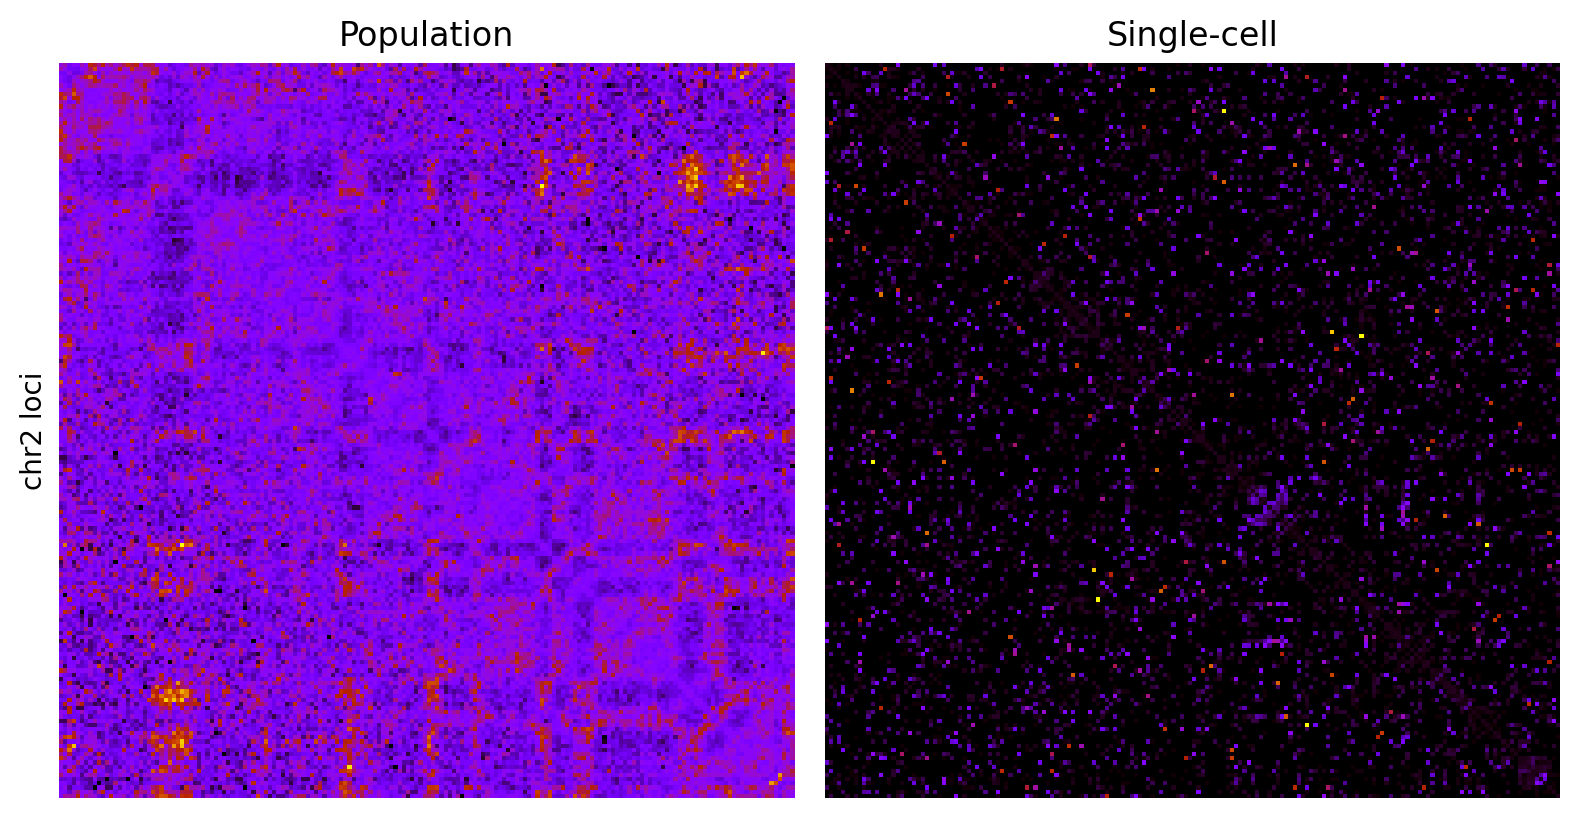

In [7]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 8, 5

cmap = 'gnuplot'
layer = 'A_oe'
A = adata.obsm[layer]
B = bdata.obsm[layer]

# remove outliers
outliers = adata.obs[adata.obs['degree_outlier']].index.to_list()

A = A.drop(outliers, axis=0).drop(outliers, axis=1)
B = B.drop(outliers, axis=0).drop(outliers, axis=1)

print(f"{A.shape=} {B.shape=}")

fig, axs = plt.subplots(1, 2, sharey=True)
axs = axs.ravel()

sns.heatmap(
    A,
    square=True,
    cmap=cmap,
    cbar=False,
    ax=axs[0]
)

axs[0].set_yticks([])
axs[0].set_xticks([])
axs[0].set_title(f"Population")
axs[0].set_xlabel("")
axs[0].set_ylabel(f"{chrom} loci")

sns.heatmap(
    B,
    square=True,
    cmap=cmap,
    cbar=False,
    ax=axs[1]
)

axs[1].set_yticks([])
axs[1].set_xticks([])
axs[1].set_title(f"Single-cell")
axs[1].set_xlabel("")
axs[1].set_ylabel(f"")

plt.tight_layout()

Text(0.5, 51.44444444444443, '')

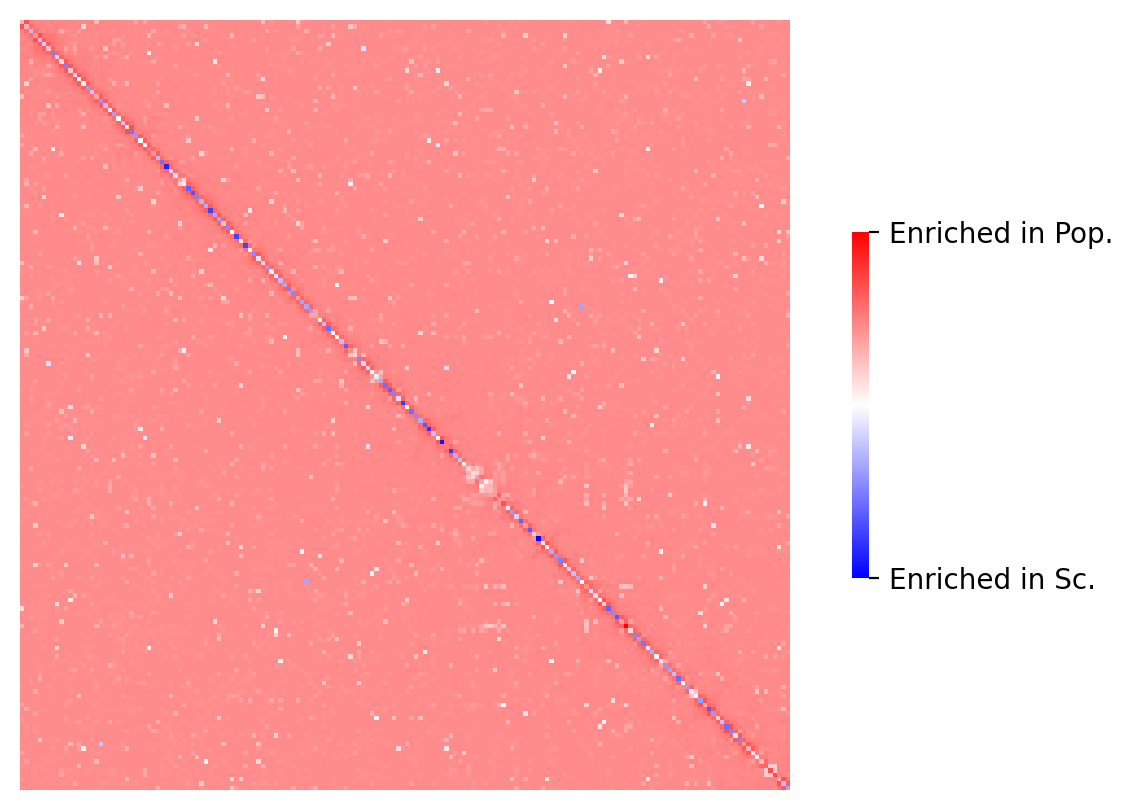

In [8]:
layer = 'A_kr'
A = adata.obsm[layer]
B = bdata.obsm[layer]

# remove outliers
outliers = adata.obs[adata.obs['degree_outlier']].index.to_list()

A = A.drop(outliers, axis=0).drop(outliers, axis=1)
B = B.drop(outliers, axis=0).drop(outliers, axis=1)

X = A - B

sns.heatmap(
    X,
    square=True,
    cmap='bwr',
    cbar_kws={'shrink' : 0.45, 'ticks' : [np.min(X), np.max(X)], 'spacing' : 'proportional'},
)

# Get the colorbar object
cbar = plt.gca().collections[0].colorbar 

# Set the tick labels
cbar.set_ticklabels(["Enriched in Sc.", "Enriched in Pop.", ]) 

plt.yticks([])
plt.xticks([])

plt.ylabel("")
plt.xlabel("")

H_a.shape=(179, 500)
H_b.shape=(179, 500)


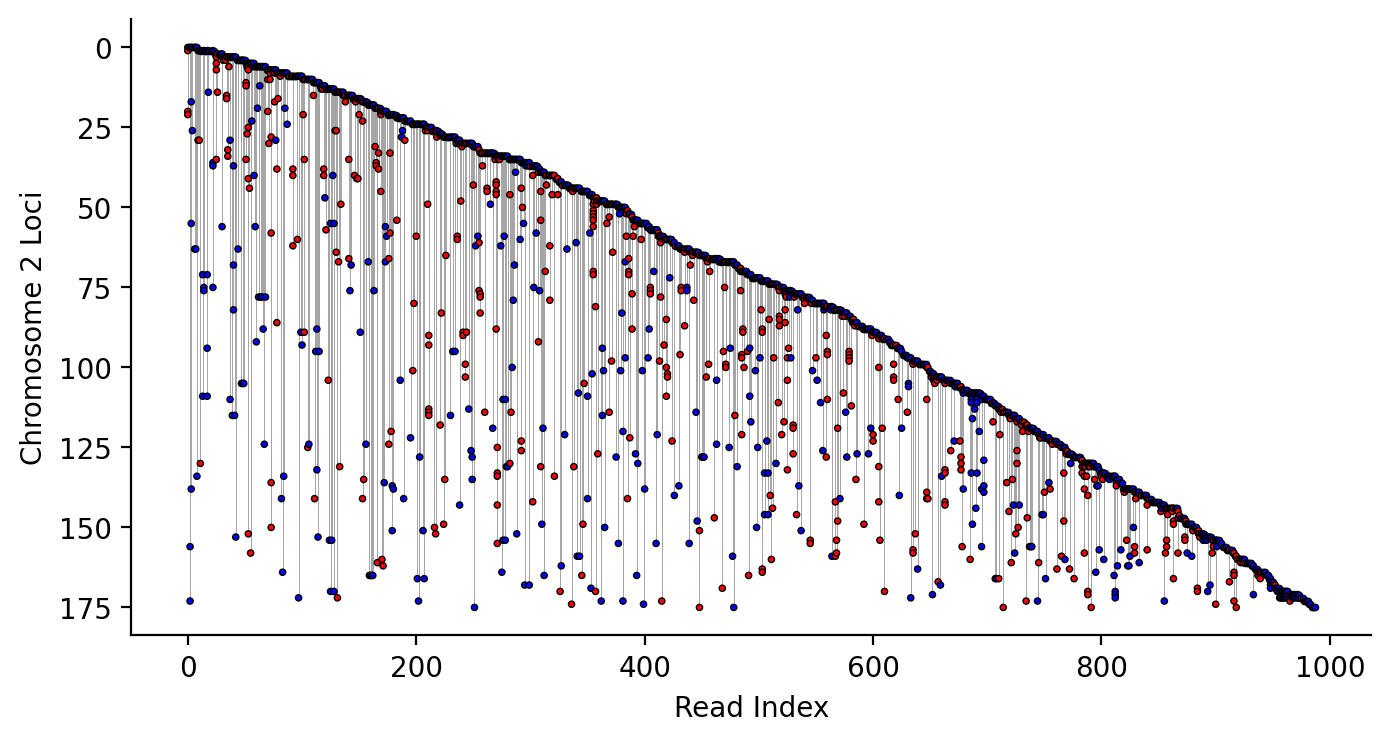

In [9]:
sample_size = 500

a_color = 'r'
b_color = 'b'

color_map = {}

H_a = adata.to_df()
H_a = H_a.T.sample(sample_size).T

H_b = bdata.to_df()
H_b = H_b.T.sample(sample_size).T

for read in H_a.columns:
    color_map[read] = a_color

for read in H_b.columns:
    color_map[read] = b_color


print(f"{H_a.shape=}")
print(f"{H_b.shape=}")

H = pd.concat([H_a, H_b], axis=1, ignore_index=False)
H = H.drop(outliers, axis=0, errors='ignore')
H = H.reset_index(drop=True)
H = ut.sort_by_lowest_index(H)

node_colors = H.columns.map(color_map).to_list()

node_params = {
    's' : 5,
    'ec' : 'k',
    'lw' : 0.5,
    'marker' : "o",
    'zorder' : 2,
}

line_params = {
    'lw' : 0.25,
    'alpha' : 0.5,
    'zorder' : 1,
}

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 8, 4


plt2.plot_incidence(
    H, node_color=node_colors,
    node_params=node_params,
    line_params=line_params,
)

# plt.title(f"Chromosome 2")
plt.ylabel("Chromosome 2 Loci")
plt.xlabel("Read Index")
sns.despine()

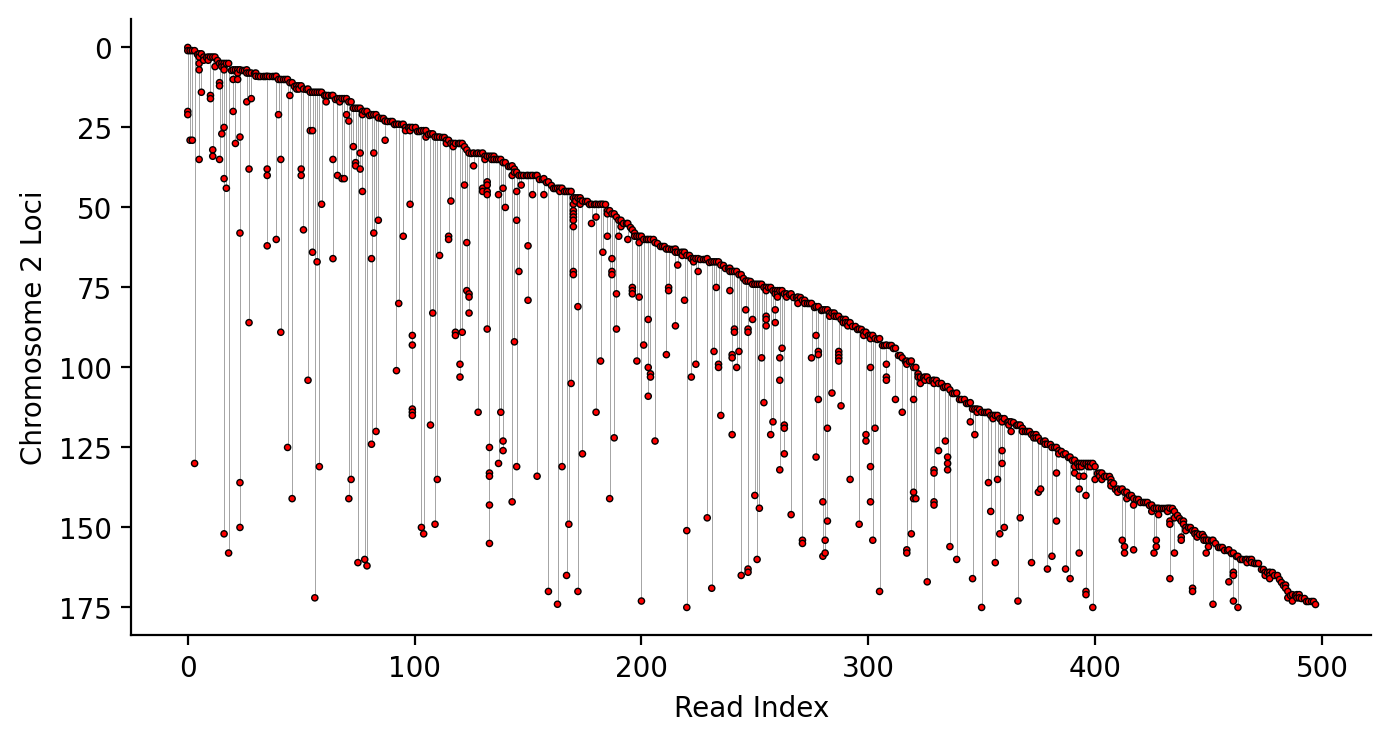

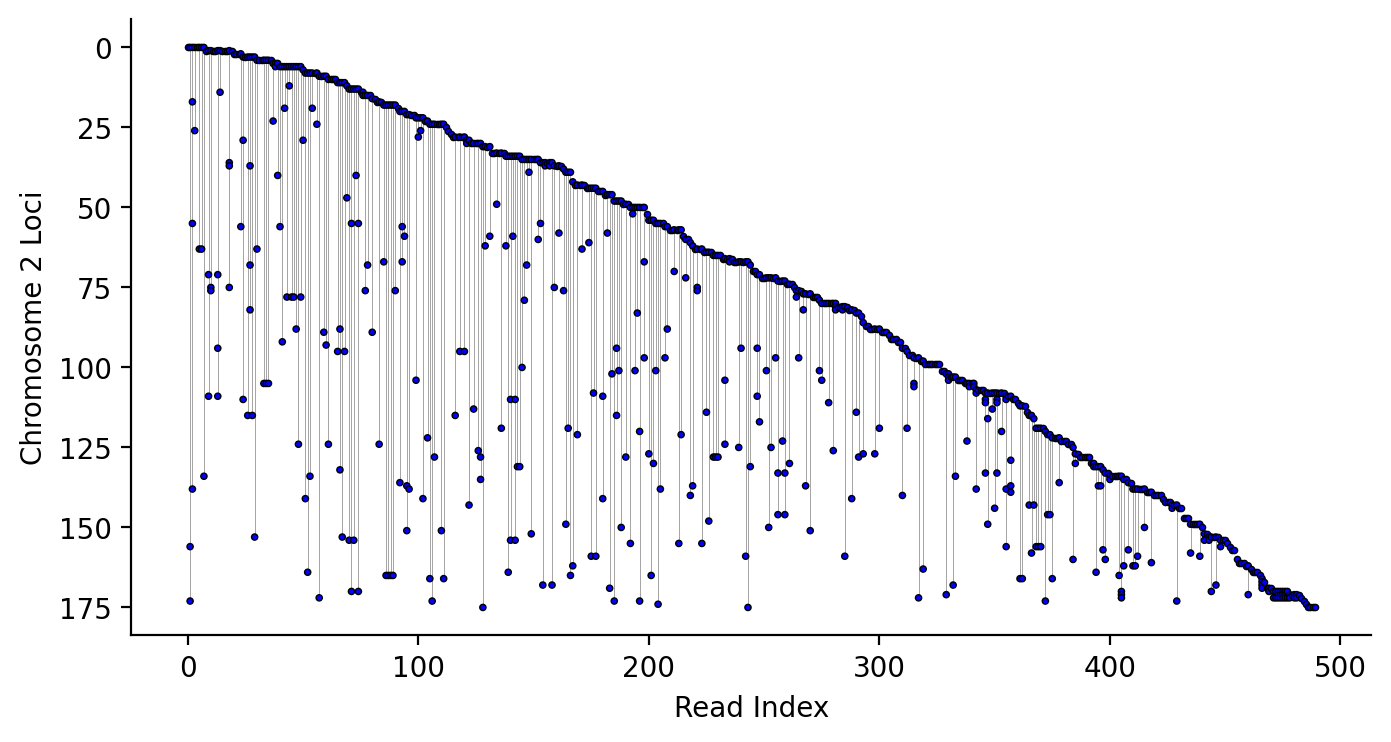

In [10]:
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 8, 4

H_a = H_a.drop(outliers, axis=0, errors='ignore')
H_a = H_a.reset_index(drop=True)
H_a = ut.sort_by_lowest_index(H_a)

plt2.plot_incidence(
    H_a, node_color='r',
    node_params=node_params,
    line_params=line_params,
)

plt.ylabel("Chromosome 2 Loci")
plt.xlabel("Read Index")
sns.despine()
plt.show()

H_b = H_b.drop(outliers, axis=0, errors='ignore')
H_b = H_b.reset_index(drop=True)
H_b = ut.sort_by_lowest_index(H_b)

plt2.plot_incidence(
    H_b, node_color='b',
    node_params=node_params,
    line_params=line_params,
)

plt.ylabel("Chromosome 2 Loci")
plt.xlabel("Read Index")
sns.despine()

plt.show()

In [11]:
# break

# Compute edge overlap

In [12]:
print(f"{adata.X.shape=}")
print(f"{bdata.X.shape=}")

adata.X.shape=(179, 186499)
bdata.X.shape=(179, 1865516)


In [13]:
# Timing for dataset 'a'
start_time_a = time.time()

print(f"{adata.X.shape=}")

a_df = adata.to_df().T
print(f"{a_df.shape=}")
a_df = a_df.drop_duplicates()
print(f"{a_df.shape=}")

end_time_a = time.time()
print(f"Execution time for dataset 'a': {end_time_a - start_time_a:.2f} seconds\n")

# Timing for dataset 'b'
start_time_b = time.time()

print(f"{bdata.X.shape=}")

b_df = bdata.to_df().T
print(f"{b_df.shape=}")
b_df = b_df.drop_duplicates()
print(f"{b_df.shape=}")

end_time_b = time.time()
print(f"Execution time for dataset 'b': {end_time_b - start_time_b:.2f} seconds")

# Total execution time
total_time = end_time_a - start_time_a + end_time_b - start_time_b
print(f"Total execution time: {total_time:.2f} seconds")

adata.X.shape=(179, 186499)
a_df.shape=(186499, 179)
a_df.shape=(55574, 179)
Execution time for dataset 'a': 0.69 seconds

bdata.X.shape=(179, 1865516)
b_df.shape=(1865516, 179)
b_df.shape=(11631, 179)
Execution time for dataset 'b': 6.32 seconds
Total execution time: 7.02 seconds


In [14]:
def zip_loci(read):
    nodes_in_hyperedge = sorted(np.nonzero(read)[0])
    ".".join(map(str, nodes_in_hyperedge))
    return ".".join(map(str, nodes_in_hyperedge))

a_hyperdges = pd.DataFrame(a_df.apply(zip_loci, axis=1), columns=['loci'])
a_hyperdges = a_hyperdges.sort_values(by='loci').reset_index(drop=False)

b_hyperdges = pd.DataFrame(b_df.apply(zip_loci, axis=1), columns=['loci'])
b_hyperdges = b_hyperdges.sort_values(by='loci').reset_index(drop=False)

print(f"{a_hyperdges.shape=}")
print(f"{b_hyperdges.shape=}")

a_hyperdges.shape=(55574, 2)
b_hyperdges.shape=(11631, 2)


In [15]:
def compare_loci(df1, df2):
  """
  Compares the loci in two pandas DataFrames.

  Args:
    df1: The first pandas DataFrame with a 'loci' column.
    df2: The second pandas DataFrame with a 'loci' column.

  Returns:
    A tuple containing three sets and three percentages:
      - common_loci: The set of loci present in both DataFrames.
      - df1_unique_loci: The set of loci unique to df1.
      - df2_unique_loci: The set of loci unique to df2.
      - perc_df1_in_df2: Percentage of df1 loci found in df2.
      - perc_df2_in_df1: Percentage of df2 loci found in df1.
      - perc_common: Percentage of common loci relative to both DataFrames.
  """

  loci1 = set(df1['loci'])
  loci2 = set(df2['loci'])

  common_loci = loci1.intersection(loci2)
  df1_unique_loci = loci1.difference(loci2)
  df2_unique_loci = loci2.difference(loci1)

  perc_df1_in_df2 = len(common_loci) / len(loci1) * 100 if loci1 else 0
  perc_df2_in_df1 = len(common_loci) / len(loci2) * 100 if loci2 else 0
  perc_common = len(common_loci) / (len(loci1) + len(loci2) - len(common_loci)) * 100 if (loci1 or loci2) else 0

  return (
      common_loci,
      df1_unique_loci,
      df2_unique_loci,
      perc_df1_in_df2,
      perc_df2_in_df1,
      perc_common,
  )

(
    common_loci,
    df1_unique_loci,
    df2_unique_loci,
    perc_df1_in_df2,
    perc_df2_in_df1,
    perc_common,
) = compare_loci(a_hyperdges, b_hyperdges)

print("common loci:", len(common_loci))
print("unique loci in df1:", len(df1_unique_loci))
print("unique loci in df2:", len(df2_unique_loci))
print(f"Percentage of df1 loci found in df2: {perc_df1_in_df2:.2f}%")
print(f"Percentage of df2 loci found in df1: {perc_df2_in_df1:.2f}%")
print(f"Percentage of common loci relative to both DataFrames: {perc_common:.2f}%")

common loci: 8203
unique loci in df1: 47371
unique loci in df2: 3428
Percentage of df1 loci found in df2: 14.76%
Percentage of df2 loci found in df1: 70.53%
Percentage of common loci relative to both DataFrames: 13.90%


In [16]:
mismatch = b_hyperdges[b_hyperdges['loci'].isin(df2_unique_loci)]
len(mismatch)
mismatch.head()

,read_name,loci
1,ffc0c3f4-a2f1-4fa1-b869-cbc615757bab,0.1.63.75.76
10,8c46e605-9dc8-5729-80c2-a16439a8a11d,0.107
11,e979f9a4-5474-5142-acc3-7f903b360050,0.107.108.109.139
12,2c0ee6c3-f2c8-4bc4-8d1e-3230301ff901,0.108
15,83d256cb-1a4b-4df7-ac5d-31d78d189535,0.113


In [17]:
missing_reads = bdata.var[bdata.var.index.isin(mismatch['read_name'].to_list())].copy()
missing_reads = missing_reads.reset_index(drop=False)
print(f"{missing_reads.shape=}")
print(f"{missing_reads['basename'].nunique()=}")
missing_reads.head()

missing_reads.shape=(3428, 12)
missing_reads['basename'].nunique()=270


,read_name,read_index,basename,mean_mapq,median_mapq,n_chromosomes,order,n_bins,read_length_bp,genes,n_genes,chrom_order
0,c55b4322-2b86-4601-8a1f-ec968f97f9c4,124,o2b67,45.250000,60.0,2,8,5,3817,Lrp1b;Myo3b,2,3
1,119ac2d9-eee6-48e8-8d7f-dd6dbbc61593,879,o3b52,57.800000,60.0,1,5,3,3736,Arhgap11a;Bfsp1,2,3
2,a1c5cb1b-5c7d-42f8-9725-cecbd1a3a265,5084,o3b52,47.352941,60.0,4,17,7,7611,Chd6;Lpin3;Mob1b;Aqr;Dck,5,4
3,30cd2b7f-86db-4ec2-a963-4f853730b362,11053,o3b87,56.062500,60.0,9,16,13,4210,Gars;Ptprd;Aldh1a1;Gtpbp4;Gpr158;Cntnap2;Nup58...,8,3
4,ad1fddd0-3812-46a2-a4b1-cd5c0dabe4e7_1,11500,o3b38,11.826087,0.0,3,23,7,6828,Gm6710;Gm14391;Gm2004;Gm14402;Chl1;Gm14392;Gm1...,9,5


In [18]:
missing_reads['median_mapq'].mean()

44.54448658109685

# most common hyperedges

In [19]:
# Timing for dataset 'a'
start_time_a = time.time()

print(f"{adata.X.shape=}")

a_df = adata.to_df().T
print(f"{a_df.shape=}")

end_time_a = time.time()
print(f"Execution time for dataset 'a': {end_time_a - start_time_a:.2f} seconds\n")

# Timing for dataset 'b'
start_time_b = time.time()

print(f"{bdata.X.shape=}")

b_df = bdata.to_df().T
print(f"{b_df.shape=}")

end_time_b = time.time()
print(f"Execution time for dataset 'b': {end_time_b - start_time_b:.2f} seconds")

# Total execution time
total_time = end_time_a - start_time_a + end_time_b - start_time_b
print(f"Total execution time: {total_time:.2f} seconds")

print()

a_hyperdges = pd.DataFrame(a_df.apply(zip_loci, axis=1), columns=['loci'])
a_hyperdges = a_hyperdges.sort_values(by='loci').reset_index(drop=False)

b_hyperdges = pd.DataFrame(b_df.apply(zip_loci, axis=1), columns=['loci'])
b_hyperdges = b_hyperdges.sort_values(by='loci').reset_index(drop=False)

print(f"{a_hyperdges.shape=}")
print(f"{b_hyperdges.shape=}")

adata.X.shape=(179, 186499)
a_df.shape=(186499, 179)
Execution time for dataset 'a': 0.17 seconds

bdata.X.shape=(179, 1865516)
b_df.shape=(1865516, 179)
Execution time for dataset 'b': 0.74 seconds
Total execution time: 0.91 seconds

a_hyperdges.shape=(186499, 2)
b_hyperdges.shape=(1865516, 2)


# check over-represented bins

In [20]:
def find_outliers_iqr(df_column):
  """
  Identifies outliers in a pandas DataFrame column using the IQR method.

  Args:
    df_column: A pandas Series representing the column to analyze.

  Returns:
    A boolean mask with True for outliers and False otherwise.
  """
  Q1 = df_column.quantile(0.15)
  Q3 = df_column.quantile(0.85)
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR
  return (df_column < lower_bound) | (df_column > upper_bound)

adata.obs['degree_outlier'] = find_outliers_iqr(adata.obs['chrom_degree'])
adata.obs[['chrom_bin', 'chrom_degree', 'degree_outlier']].sort_values(by='chrom_degree', ascending=False).head()

,chrom_bin,chrom_degree,degree_outlier
bin_name,,,
chr2:98,98,93161,True
chr2:177,177,3700,True
chr2:174,174,2636,False
chr2:176,176,2293,False
chr2:77,77,2283,False


In [21]:
# MOst common 

In [22]:
a_common = pd.DataFrame(a_hyperdges['loci'].value_counts())
b_common = pd.DataFrame(b_hyperdges['loci'].value_counts())

common = pd.merge(
    a_common, b_common,
    how='inner',
    left_index=True,
    right_index=True,
).reset_index(drop=False)
common.columns = ['contact', 'population', 'singlecell']

common['order'] = common['contact'].apply(lambda x : x.count(".") + 1)
common = common[common['order'] > 2]

common['pop_rank'] = common['population'].rank(ascending=False)
common['sc_rank'] = common['singlecell'].rank(ascending=False)

print(f"{common.shape=}")
common.head(15)

common.shape=(1410, 6)


,contact,population,singlecell,order,pop_rank,sc_rank
228,172.173.174,93,13794,3,1.0,1.0
340,171.173.174,56,6549,3,2.0,3.0
360,171.172.173.174,38,13530,4,3.0,2.0
373,0.1.95,31,2,3,4.0,731.0
385,95.172.173,28,381,3,5.0,40.0
399,95.173.174,24,574,3,6.0,27.0
407,169.170.171,22,186,3,7.5,98.0
411,171.172.174,22,1651,3,7.5,9.0
415,171.172.173,21,843,3,9.5,16.0
417,167.168.169,21,2,3,9.5,731.0


In [23]:
# break

In [100]:
n_top_contacts = 3

locus_list = common['contact'].head(n_top_contacts).values
locus_list = [x.split(".") for x in locus_list]
locus_list = list(set([item for sublist in locus_list for item in sublist]))
print("most common loci: ")
print(locus_list)

locus_list = [f"{chrom}:{x}" for x in locus_list]
genes = adata[locus_list, :].obs['genes'].values
genes = [x.split(";") for x in genes]
genes = [item for sublist in genes for item in sublist]
print(f"\n{len(genes)=}\n")
genes[:10]

most common loci: 
['173', '172', '174', '171']

len(genes)=84



['Gm14371',
 'Ppp4r1l-ps',
 'Gm10714',
 'Atp5k-ps2',
 'Gm14642',
 'Vapb',
 'Zbp1',
 'Gm30143',
 '1700021F07Rik',
 'Npepl1']

In [26]:
print(genes)

['Gm14371', 'Ppp4r1l-ps', 'Gm10714', 'Atp5k-ps2', 'Gm14642', 'Vapb', 'Zbp1', 'Gm30143', '1700021F07Rik', 'Npepl1', 'Vamp7-ps', '1700010B08Rik', 'Pmepa1', 'Ankrd60', '1700039O17Rik', 'Rab22a', 'Gm14336', 'Stx16', 'Pck1', 'Pmepa1os', 'Spo11', 'Gm57436', 'Rae1', 'Fam209', 'Mc3r', 'Gm14273', 'Fam210b', 'Gm14455', 'Gm57426', 'Tfap2c', 'Gm14275', 'Ctcfl', 'Gm56447', 'Gm36462', 'Gcnt7', 'Cstf1', 'Ctcflos', 'Rbm38', 'Rtf2', 'Gm56446', 'Gm14453', 'Gm14303', 'Bmp7', 'Cass4', 'Pck1', 'Aurka', 'Ctsz', 'Rpl30-ps5', 'Gm14444', 'Gm10714', 'Gm46781', 'Atp5f1e', 'Tubb1', 'Gm16355', 'Gm14392', 'Mir296', 'Gm14616', 'Gnasas1', 'Gm56449', 'Gm14385', 'Prelid3b', 'Gm14618', 'Gm14387', 'Zfp831', 'Gm14617', 'Gnas', 'Gm14393', 'Vmn1r-ps1', 'Mir298', 'Gm16354', 'Gm14399', 'Nelfcd', 'Edn3', 'Gm14445', 'Gm14266', '1700028P15Rik', 'Gm14641', 'Gm14271', 'Cbln4', 'Gm26489', '1700007M16Rik', 'Gm14274', 'Gm14640', 'Gm14272']


In [27]:
# database = 'Mouse_Gene_Atlas'
# edf = gget.enrichr(genes, database=database)

# pd.set_option('display.max_colwidth', 100)
# edf[['path_name', 'adj_p_val', 'overlapping_genes']].head()

In [28]:
obs = adata.obs.copy()

in_list = obs[obs.index.isin(locus_list)]
out_list = obs[~obs.index.isin(locus_list)]

print(f"{'In List Shape:':<20} {in_list.shape}")
print(f"{'Out List Shape:':<20} {out_list.shape}")
print("-" * 30)

columns = [
    'n_genes', 'ATACSeq_1', 'ATACSeq_2', 'ATACSeq_3',
    'CTCF', 'H3K27ac', 'H3K27me3', 
]

data = []
for column in columns:
    data.append([column, in_list[column].mean(), out_list[column].mean()])

df = pd.DataFrame(data, columns=['Column', 'In List Mean', 'Out List Mean'])
print(df.to_markdown(index=False, numalign="left", stralign="left"))

In List Shape:       (4, 23)
Out List Shape:      (175, 23)
------------------------------
| Column    | In List Mean   | Out List Mean   |
|:----------|:---------------|:----------------|
| n_genes   | 21             | 18.92           |
| ATACSeq_1 | 0.764438       | 0.675055        |
| ATACSeq_2 | 0.692217       | 0.559281        |
| ATACSeq_3 | 0.740417       | 0.617654        |
| CTCF      | 0.9085         | 0.682845        |
| H3K27ac   | 0.855873       | 0.661525        |
| H3K27me3  | 0.936859       | 0.682185        |


In [85]:
order_threshold = 2
a_locus = adata[adata.obs.index.isin(locus_list), :].copy()
a_locus = a_locus[:, a_locus.X.sum(axis=0) > order_threshold].copy()

print(a_locus)
print()

b_locus = bdata[bdata.obs.index.isin(locus_list), :].copy()
b_locus = b_locus[:, b_locus.X.sum(axis=0) > order_threshold].copy()
b_locus


AnnData object with n_obs × n_vars = 4 × 78
    obs: 'bin_index', 'bin_start', 'bin_end', 'bin', 'chrom', 'chrom_bin', 'degree', 'genes', 'n_genes', 'ATACSeq_1', 'ATACSeq_2', 'ATACSeq_3', 'CTCF', 'H3K27ac', 'H3K27me3', 'RNA_1', 'RNA_2', 'RNA_3', 'RNA_4', 'RNA_5', 'RNA_6', 'chrom_degree', 'degree_outlier'
    var: 'read_index', 'basename', 'mean_mapq', 'median_mapq', 'n_chromosomes', 'order', 'n_bins', 'read_length_bp', 'genes', 'n_genes', 'chrom_order'
    uns: 'base_resolution', 'chrom_sizes', 'gene_map'
    obsm: 'A', 'A_kr', 'A_oe'



AnnData object with n_obs × n_vars = 4 × 889
    obs: 'bin_index', 'bin_start', 'bin_end', 'bin', 'chrom', 'chrom_bin', 'degree', 'genes', 'n_genes', 'ATACSeq_1', 'ATACSeq_2', 'ATACSeq_3', 'CTCF', 'H3K27ac', 'H3K27me3', 'RNA_1', 'RNA_2', 'RNA_3', 'RNA_4', 'RNA_5', 'RNA_6', 'chrom_degree'
    var: 'read_index', 'basename', 'mean_mapq', 'median_mapq', 'n_chromosomes', 'order', 'n_bins', 'read_length_bp', 'genes', 'n_genes', 'chrom_order'
    uns: 'base_resolution', 'chrom_sizes', 'gene_map'
    obsm: 'A', 'A_kr', 'A_oe'

# common gene interactions

In [183]:
def make_frame(common_elements):
  df = pd.DataFrame(common_elements, columns=['gene_name', 'contact_count'])
  df['gene_name'] = df['gene_name'].apply(lambda x: "-".join(x))
  df = df[df['gene_name'] != ""]
  df = df.set_index('gene_name')
  df['rank'] = df['contact_count'].rank(ascending=False)
  return df


def find_common_interactions(data, interaction_size):
  """
  Finds the most common interactions of a specified size from a list of gene interactions.

  Args:
    data: A list of strings, where each string is a semicolon-separated list of genes.
    interaction_size: The size of the interactions to find (e.g., 2 for pairwise interactions).

  Returns:
    A list of tuples, where each tuple contains an interaction (a tuple of genes) and its count.
  """

  all_interactions = []
  for item in data:
    genes = item.split(';')
    if len(genes) >= interaction_size:
      for interaction in combinations(genes, interaction_size):
        all_interactions.append(tuple(sorted(interaction)))

  interaction_counts = Counter(all_interactions)
  return interaction_counts.most_common()

order = 1
n_interactions = 2

a_common = find_common_interactions(adata.var['genes'].to_list(), order)
print("in population:")
print(a_common[:n_interactions])
print()

# remove amplification bias
b_genes = bdata.var[['basename', 'genes']].drop_duplicates().copy()
b_common = find_common_interactions(b_genes['genes'].to_list(), order)
print("in singel-cell:")
print(b_common[:n_interactions])
print()

a_df = make_frame(a_common)
b_df = make_frame(b_common)

df = pd.merge(
    a_df, b_df, how='inner',
    left_index=True,
    right_index=True,
    suffixes=['_pop', '_sc'],
).reset_index(drop=False)

df.head(10)

in population:
[(('',), 14727), (('Chl1',), 5593)]

in singel-cell:
[(('Chl1',), 4055), (('Gm14326',), 2926)]



,gene_name,contact_count_pop,rank_pop,contact_count_sc,rank_sc
0,Chl1,5593,1.0,4055,1.0
1,Macrod2,3562,2.0,1439,11.0
2,Lrp1b,3550,3.0,854,28.0
3,Lrrc4c,2239,4.0,507,47.5
4,Ptprt,2178,5.0,476,51.0
5,Etl4,1988,6.0,994,22.0
6,Celf2,1898,7.0,591,42.0
7,Arhgap15,1371,8.0,280,87.5
8,Gm33838,1360,9.0,1186,16.0
9,Plcb1,1355,10.0,307,81.5


At quantile 0.995, count threshold is ~527


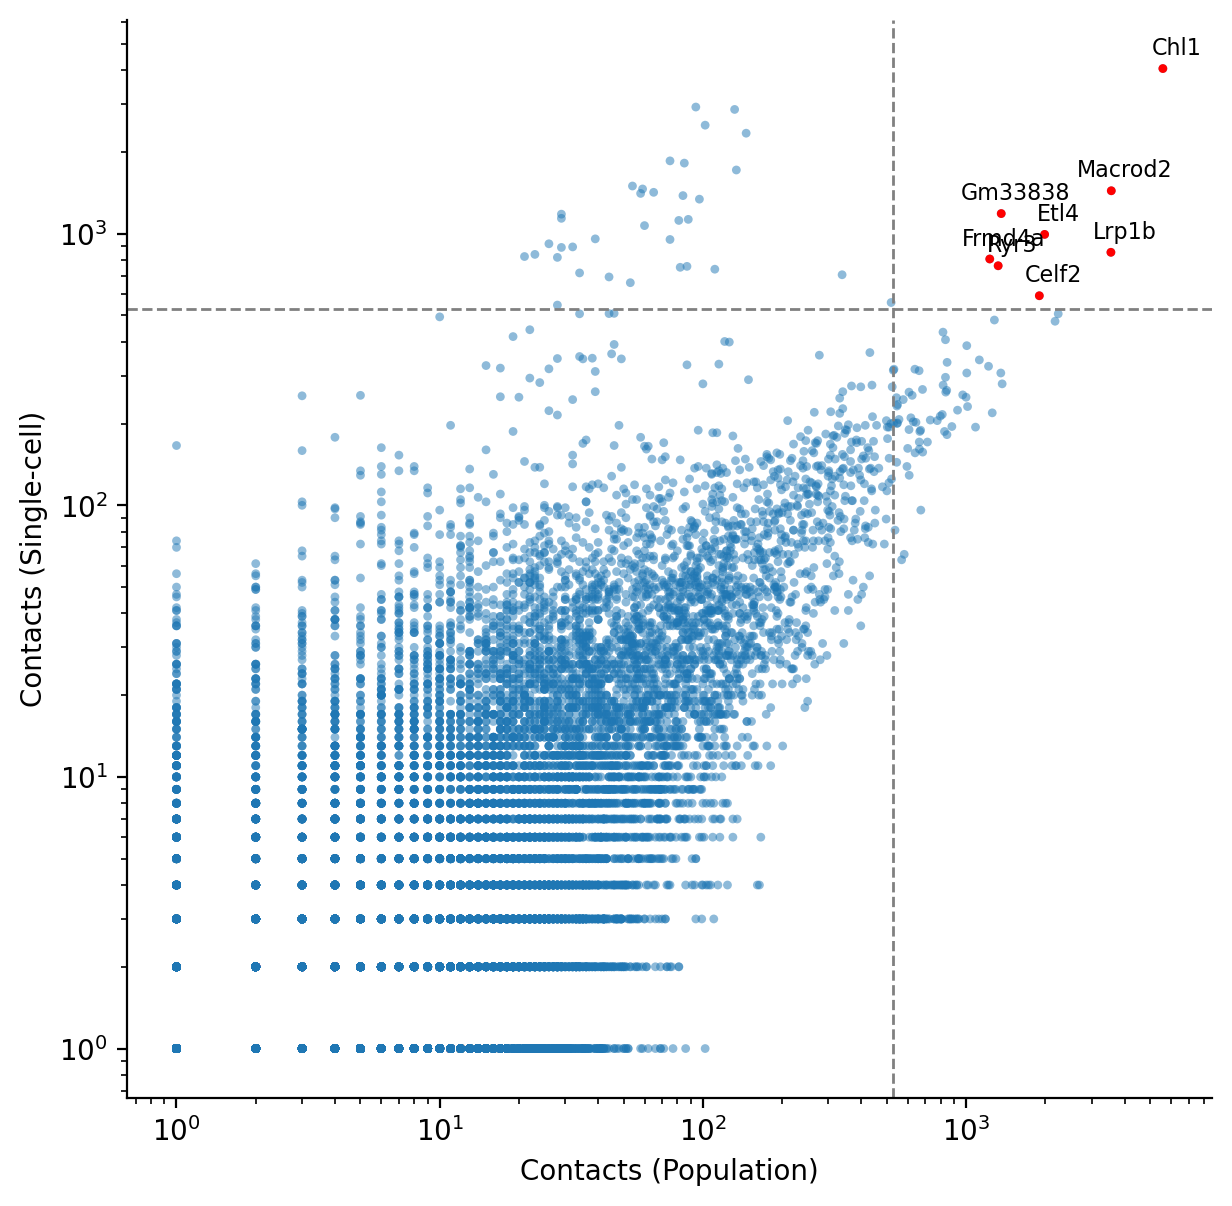

,gene_name,contact_count_pop,rank_pop,contact_count_sc,rank_sc
0,Chl1,5593,1.0,4055,1.0
1,Macrod2,3562,2.0,1439,11.0
2,Lrp1b,3550,3.0,854,28.0
5,Etl4,1988,6.0,994,22.0
6,Celf2,1898,7.0,591,42.0
8,Gm33838,1360,9.0,1186,16.0
10,Ryr3,1324,11.0,762,33.0
13,Frmd4a,1230,14.0,807,32.0


In [184]:
# Plotting the scatter plot with log scales and annotations
q = 0.995
threshold = np.quantile(df['contact_count_pop'], q)
print(f"At quantile {q}, count threshold is ~{int(threshold)}")

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 7, 7

sns.scatterplot(
    data=df, 
    x='contact_count_pop', 
    y='contact_count_sc',
    ec='none',
    alpha=0.5,
    s=10,
)

# Adding lines to indicate thresholds
plt.axvline(threshold, color='gray', lw=1, linestyle='--')
plt.axhline(threshold, color='gray', lw=1, linestyle='--')

# Identifying and coloring points beyond the threshold
df_filtered = df[(df['contact_count_pop'] > threshold) & (df['contact_count_sc'] > threshold)]

sns.scatterplot(
    data=df_filtered, 
    x='contact_count_pop', 
    y='contact_count_sc', 
    color='red',
    ec='none',
    s=10,
)

# Annotating the red points
for i, row in df_filtered.iterrows():
    plt.annotate(
        row['gene_name'], (row['contact_count_pop'], row['contact_count_sc']), 
        textcoords='offset points', xytext=(5, 5), ha='center', fontsize=8,
    )

plt.yscale('log')
plt.xscale('log')
plt.xlabel('Contacts (Population)')
plt.ylabel('Contacts (Single-cell)')
sns.despine()
plt.show()

df_filtered

In [ ]:
break

# Look for specific genes

In [93]:
query_gene = 'Sox2'

a_query = adata[:, adata.var['genes'].str.contains(query_gene)].copy()
a_query = a_query[a_query.X.sum(axis=1) > 1, :].copy()

b_query = bdata[:, bdata.var['genes'].str.contains(query_gene)].copy()
b_query = b_query[b_query.X.sum(axis=1) > 1, :].copy()

print(a_query)
print()
print(b_query)

AnnData object with n_obs × n_vars = 95 × 187
    obs: 'bin_index', 'bin_start', 'bin_end', 'bin', 'chrom', 'chrom_bin', 'degree', 'genes', 'n_genes', 'ATACSeq_1', 'ATACSeq_2', 'ATACSeq_3', 'CTCF', 'H3K27ac', 'H3K27me3', 'RNA_1', 'RNA_2', 'RNA_3', 'RNA_4', 'RNA_5', 'RNA_6', 'chrom_degree', 'degree_outlier'
    var: 'read_index', 'basename', 'mean_mapq', 'median_mapq', 'n_chromosomes', 'order', 'n_bins', 'read_length_bp', 'genes', 'n_genes', 'chrom_order'
    uns: 'base_resolution', 'chrom_sizes', 'gene_map'
    obsm: 'A', 'A_kr', 'A_oe'

AnnData object with n_obs × n_vars = 16 × 2821
    obs: 'bin_index', 'bin_start', 'bin_end', 'bin', 'chrom', 'chrom_bin', 'degree', 'genes', 'n_genes', 'ATACSeq_1', 'ATACSeq_2', 'ATACSeq_3', 'CTCF', 'H3K27ac', 'H3K27me3', 'RNA_1', 'RNA_2', 'RNA_3', 'RNA_4', 'RNA_5', 'RNA_6', 'chrom_degree'
    var: 'read_index', 'basename', 'mean_mapq', 'median_mapq', 'n_chromosomes', 'order', 'n_bins', 'read_length_bp', 'genes', 'n_genes', 'chrom_order'
    uns: 'base

In [94]:
a_query.var['genes']

read_name
099d3759-8ae3-4d32-90f1-4f9a1381963c                                  Or4a68;Plcb4;Sox2ot
a253eb0a-af67-48c0-86a8-b03f47410b69                           Tanc1;Plxdc2;Otud7b;Sox2ot
4e857de8-4b19-4380-aca4-edf57ce759e9    Tbc1d20;Gm14252;Kif16b;Gm29502;Qser1;Platr14;E...
c8fddbd8-9225-49cb-8cad-396ce9eacf7c                               Gm13464;Gm13394;Sox2ot
e8de4f1a-7202-46b5-9c3e-d972a14c4ba2    Gm28960;Stx8;Vsig4;Tfeb;Cntnap5b;Zkscan2;Ehmt1...
                                                              ...                        
adf76302-71f4-45cb-a9cd-6a67bf204a75                  Auts2;Ncam1;Kiz;Sox6;Colec12;Sox2ot
d15f5761-ed64-4a3e-aab7-879b8f898bb2                                Cobll1;Tmem144;Sox2ot
a1b07d94-1013-46b4-ad76-7851c8e66040                                               Sox2ot
e9b77441-85e5-4f6e-a066-91c69f50d0fd                                       Sox2ot;Gm14221
db1be401-bb60-485d-9202-f9fb739abd15                              Zfp385b;Arhgef28;Sox2ot


In [96]:
adata.var['genes'].to_list()[:5]

['Taf4;Ccnd3',
 'Zfp385b',
 'Dnajc7;Gfod1;Fbxl20;Zfp385c;Kif16b;Pcbp3;Klhl10;Gm11525;Prex1;Cdk5rap2',
 'Atp5po;Dyrk1a;Runx1;Robo1;Senp7;Fmnl2;Gm30695',
 'Ttyh2;Dll4;Gm26749;Birc6']

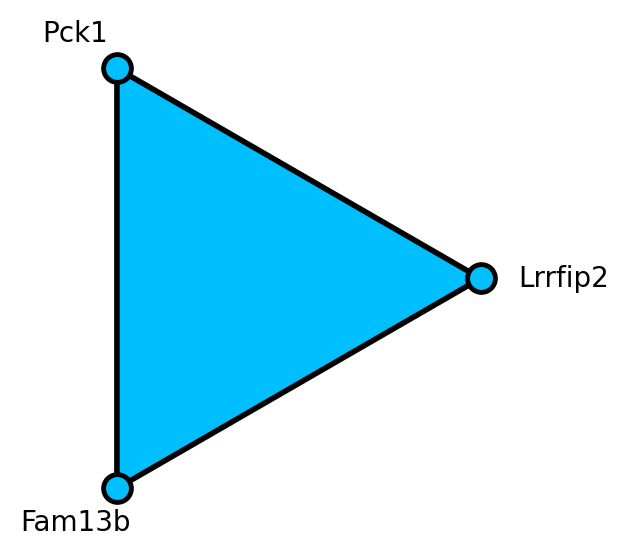

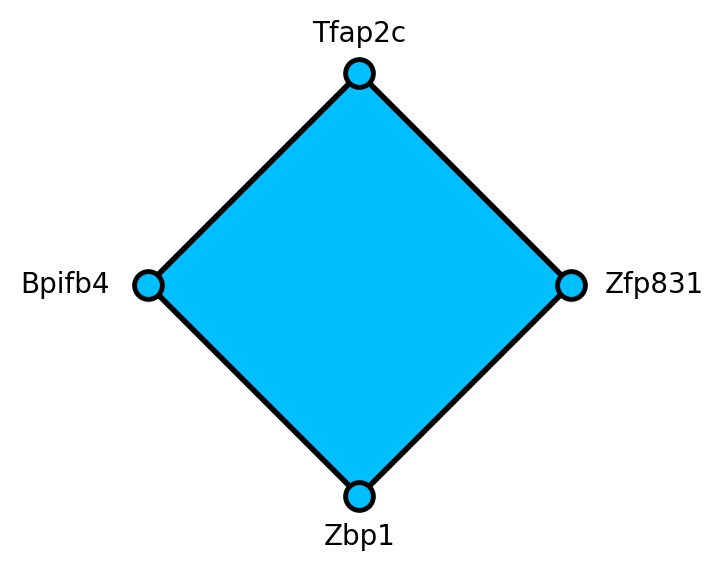

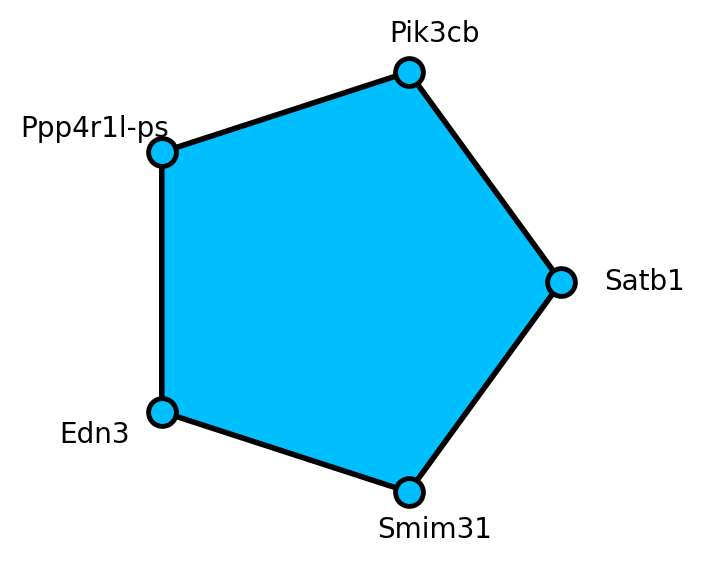

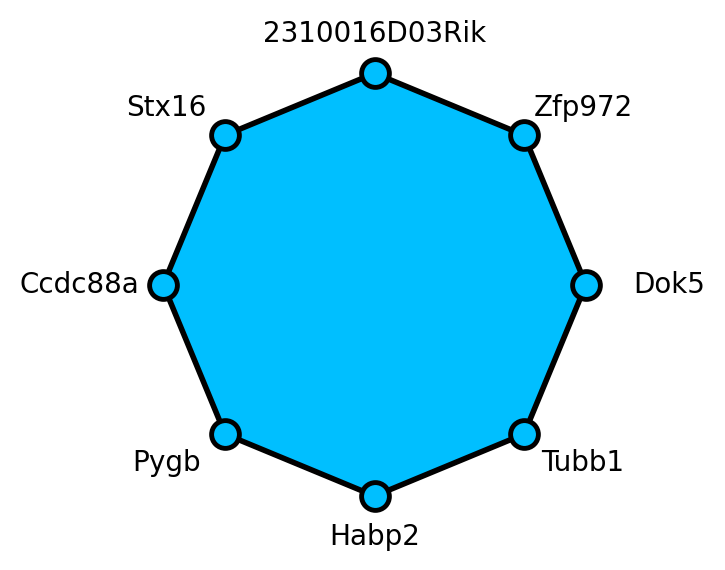

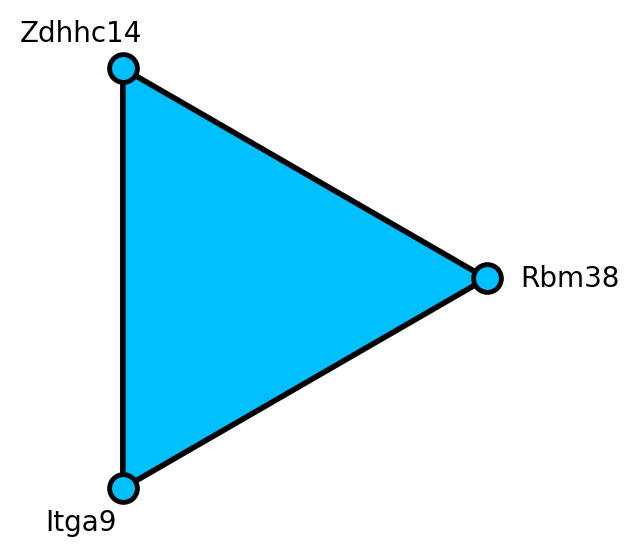

['Lrrfip2;Pck1;Fam13b',
 'Zfp831;Tfap2c;Bpifb4;Zbp1',
 'Satb1;Pik3cb;Ppp4r1l-ps;Edn3;Smim31',
 'Dok5;Zfp972;2310016D03Rik;Stx16;Ccdc88a;Pygb;Habp2;Tubb1',
 'Rbm38;Zdhhc14;Itga9']

In [84]:
def plot_polygons(gene_list):
  """
  Plots a simple polygon for each element in the given list, 
  with each gene annotating a vertex.

  Args:
    gene_list: A list of strings, where each string contains 
               semicolon-separated gene names.
  """

  for i, genes in enumerate(gene_list):
    gene_names = genes.split(';')
    num_genes = len(gene_names)

    # Generate coordinates for the vertices
    angles = np.linspace(0, 2*np.pi, num_genes, endpoint=False)
    x = np.cos(angles)
    y = np.sin(angles)

    # Create the plot
    plt.figure()
    plt.fill(
        x, y, 
        linewidth=2, 
        alpha=1,
        c='deepskyblue', 
        edgecolor='k',
    )

    # Annotate the vertices with gene names, placing them outside
    for j, gene in enumerate(gene_names):
      angle_rad = angles[j]
      # Calculate annotation position outside the polygon
      text_x = 1.2 * np.cos(angle_rad)  # Adjust 1.2 for distance from the vertex
      text_y = 1.2 * np.sin(angle_rad)
      plt.plot(
          x[j], y[j], 
          markersize=10,
          marker="o",
          c='deepskyblue',
          markeredgecolor='k',
          markeredgewidth=1.75,
      )
        
      plt.annotate(
          gene, (x[j], y[j]),
          textcoords="offset points", 
          xytext=(text_x*25, text_y*12),
          ha='center', va="center"
      ) 

    plt.axis('equal')
    plt.xticks([])  # Remove x-axis ticks
    plt.yticks([])  # Remove y-axis ticks
    sns.despine(left=True, bottom=True)
    plt.show()

plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.figsize'] = 3, 3

sample_genes = locus.var['genes'].sample(5).to_list()
plot_polygons(sample_genes)
sample_genes

In [41]:
# plot 
locus.var['genes'].values

['Nfatc2;Asic2;Gnasas1;Ripor3', 'Rae1;Gnas;Gm50294', 'Gm14266;Gcnt2', 'Zfp831;Bmp7;Ctcflos;Pmepa1', 'Dlgap4;Spag4;Lmo2;Ctcfl;Prelid3b', ..., 'Zfp831', 'Vangl2', 'Lrrfip2;Pck1;Fam13b', 'Pck1;Tubb1', 'Fam210b;Xpnpep3;Ppp4r1l-ps']
Length: 78
Categories (75, object): ['', '1700021F07Rik;Med13l;Mtg2;Larp4;Gnas;Htr4;Pde..., '1700026F02Rik;Atp5k-ps2;Ctcfl', '4930480M12Rik;Nelfcd', ..., 'Zfp831;Gm14641;Hpse;Gabrd;Cd276', 'Zfp831;Tfap2c;Bpifb4;Zbp1', 'Zfp972;Bmp7', 'Zfp972;Gm14402;Plekha5']

In [29]:
break

SyntaxError: 'break' outside loop (668683560.py, line 1)

In [ ]:
# a_locus = adata[locus_list, :].copy()
# a_locus = a_locus[:, a_locus.X.sum(axis=0) > 1]
# a_locus

In [ ]:
# H_a = a_locus.to_df()

# node_params = {
#     's' : 1,
#     'ec' : 'k',
#     'lw' : 1,
#     'marker' : ".",
#     'zorder' : 2,
# }

# line_params = {
#     'lw' : 0.1,
#     'alpha' : 0.5,
#     'zorder' : 1,
# }

# plt.rcParams['figure.dpi'] = 200
# plt.rcParams['figure.figsize'] = 8, 5

# pdf = ut.sort_by_lowest_index(H_a)

# plt2.plot_incidence(
#     pdf, 
#     node_color='k',
#     node_params=node_params,
#     line_params=line_params,
# )

# plt.title(f"Chromosome 2")

In [ ]:
break

In [ ]:
# print(genes)

In [ ]:
obs = adata.obs.copy()

in_list = obs[obs.index.isin(locus_list)]
out_list = obs[~obs.index.isin(locus_list)]

print(f"{'In List Shape:':<20} {in_list.shape}")
print(f"{'Out List Shape:':<20} {out_list.shape}")
print("-" * 30)

columns = [
    'n_genes', 'ATACSeq_1', 'ATACSeq_2', 'ATACSeq_3',
    'CTCF', 'H3K27ac', 'H3K27me3', 
]

data = []
for column in columns:
    data.append([column, in_list[column].mean(), out_list[column].mean()])

df = pd.DataFrame(data, columns=['Column', 'In List Mean', 'Out List Mean'])
print(df.to_markdown(index=False, numalign="left", stralign="left"))

In [ ]:
in_list

In [ ]:
# edf = gget.enrichr(genes, database='ontolgy')
# edf

In [ ]:
print(f"{'Tfap2c' in genes=}")
print(f"{'Bmp7' in genes=}")
print(f"{'Cstf1' in genes=}")
print(f"{'Ctcfl' in genes=}")

In [ ]:

print(adata['chr2:174', :].obs['genes'].values[0].split(";"))

In [ ]:
bdata['chr2:95', :].obs.head()

In [ ]:
adata.obs['RNA_1'].median()

In [ ]:
a_hyperdges.head()

In [ ]:
break

In [ ]:
break